# Executive Order Embeddings

In [ ]:
%run notebooks/Setup.ipynb

import pandas
import numpy
import re
import json
from sentence_transformers import SentenceTransformer
import os
import pandas
from concurrent.futures import ThreadPoolExecutor
import queue
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Embed EOs

In [ ]:
# cpu
"""
models = [
    [0, SentenceTransformer("Salesforce/SFR-Embedding-2_R")]
]
"""

# gpu
num_gpus = 1
models = [
    [i, SentenceTransformer("Salesforce/SFR-Embedding-2_R", device=f'cuda:{i}')] for i in range(num_gpus)
]

In [ ]:
# create batches of EOs to embed
eo_dir = 'data/executive_orders/raw/'
eo_paths = os.listdir(eo_dir)

def batched(list_in, batch_size):
    return [list_in[i * batch_size:(i + 1) * batch_size] for i in range((len(list_in) + batch_size - 1) // batch_size )]

eo_paths_batches = batched(eo_paths, 10)

In [ ]:
# how to embed
if not os.path.exists('data/executive_orders/embeddings'):
    os.makedirs('data/executive_orders/embeddings')

def embed_batch(batch_i, batch, model):
    eos = []
    for path in batch:
        with open(eo_dir + path, 'r') as f:
            eo_doc = json.load(f)
        eos.append('\n'.join(eo_doc['content']))

    embeddings = model.encode(list(map(lambda x: str(x), eos)))

    df = pandas.DataFrame(embeddings)
    df.insert(0, 'file', batch)
    df.to_csv(f'data/executive_orders/embeddings/batch_{batch_i}.csv')

In [ ]:
# perform the emdeddings
model_pool = queue.Queue()
for model in models:
    model_pool.put(model)

def process_batch(i, batch):
    # block until a model becomes available
    model = model_pool.get()
    try:
        embed_batch(i, batch, model[1])
        print(f"Embedded batch {i} with model {model[0]}")
    finally:
        model_pool.put(model)

with ThreadPoolExecutor(max_workers=len(models)) as executor:
    for i, batch in enumerate(eo_paths_batches):
        executor.submit(process_batch, i, batch)

## Clustering

In [2]:
embeddings_dir = 'data/executive_orders/embeddings/'
embeddings_paths = os.listdir(embeddings_dir)

def load_csv(file_name):
    return pandas.read_csv(embeddings_dir + file_name, index_col=0)

with ThreadPoolExecutor() as executor:
    embeddings_dfs = list(executor.map(load_csv, embeddings_paths))

embeddings_df = pandas.concat(embeddings_dfs, ignore_index=True)
embeddings = embeddings_df.iloc[:, 1:].to_numpy()

In [49]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(embeddings)
embeddings_df['cluster'] = clusters

output_path = 'data/executive_orders/clusters.csv'
embeddings_df[["file", "cluster"]]\
    .sort_values(by=["cluster", "file"])\
    .to_csv(output_path, index=False)

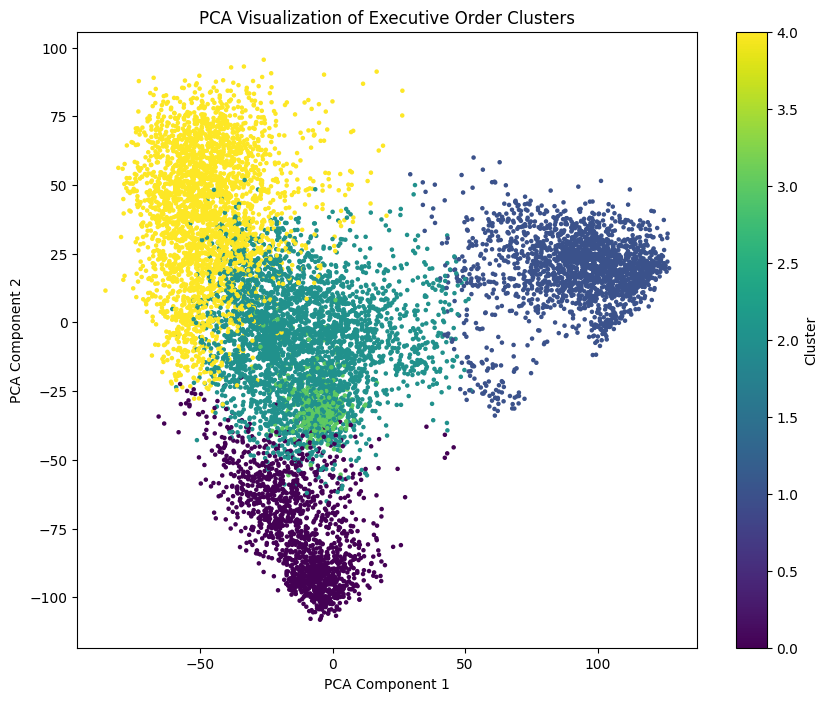

In [50]:
# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# combine the pca results to the original embeddings_df
embeddings_df['pca1'] = pca_result[:, 0]
embeddings_df['pca2'] = pca_result[:, 1]

# Create a scatter plot of the PCA results, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Executive Order Clusters')
plt.show()

In [34]:
# find 5 rows close to (-50, 50) and print them
def find_closest_point(x, y, df):
    distances = numpy.sqrt((df['pca1'] - x) ** 2 + (df['pca2'] - y) ** 2)
    closest_points = distances.nsmallest(5).index
    for i in closest_points:
        print(df.iloc[i]['file'])

find_closest_point(-35, 49, embeddings_df)

executive-order-14218-ending-taxpayer-subsidization-open-borders.json
executive-order-12294-suspension-litigation-against-iran.json
executive-order-13183-establishment-the-presidents-task-force-puerto-ricos-status.json
executive-order-keeping-education-accessible-and-ending-covid-19-vaccine-mandates-schools.json
executive-order-13295-revised-list-quarantinable-communicable-diseases.json


In [42]:
embeddings_df[['file', 'cluster', 'pca1', 'pca2']] \
    .sort_values(by=['file']) \
    .to_csv('data/executive_orders/pca.csv', index=False)